## Category Encoding: One-Hot vs. Hashing vs. Target vs. James-Stein

In this experiment we're going to see how category variables can be encoded with One-Hot, Hashing, Target and James-Stein encoders and how the encoded data affects model performance. 

We're going to use the Titanic data set to predict the survival outcome of the passengers with the Random Forest Classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot')

import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
full_data = pd.read_csv("titanic.csv")
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body,Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN,3.0


### Handling missing data

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  WikiId       889 non-null    float64
 13  Name_wiki    889 non-null    object 
 14  Age_wiki     887 non-null    float64
 15  Hometown     889 non-null    object 
 16  Boarded      889 non-null    object 
 17  Destination  889 non-null    object 
 18  Lifeboat     345 non-null    object 
 19  Body    

In [4]:
for col in full_data.columns:
    print("Column: ", col)
    print("Unique:", len(full_data[col].unique()))
    print(full_data[col].value_counts())
    print("")

Column:  PassengerId
Unique: 891
891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64

Column:  Survived
Unique: 2
0.0    549
1.0    342
Name: Survived, dtype: int64

Column:  Pclass
Unique: 3
3    491
1    216
2    184
Name: Pclass, dtype: int64

Column:  Name
Unique: 891
Abbott, Mrs. Stanton (Rosa Hunt)                         1
Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)    1
Fortune, Miss. Mabel Helen                               1
Ilmakangas, Miss. Pieta Sofia                            1
Ohman, Miss. Velin                                       1
                                                        ..
Murphy, Miss. Margaret Jane                              1
Pasic, Mr. Jakob                                         1
Mitkoff, Mr. Mito                                        1
Olsvigen, Mr. Thor Anderson                              1
Smart, Mr. John Montgomery                   

We see that the "Age" column from the original data set has a lot of missing values, so we're going to use the "Age_wiki" column instead. "Embarked" and "Boarded" are similar, however, we're going to use "Boarded", because it has an additional port "Belfast".

In [5]:
predictors = ["Age_wiki", "Sex", "Pclass", "SibSp", "Parch", "Fare", "Boarded", "Ticket"]
outcome = "Survived"

In [6]:
data = full_data[predictors].copy()
data[outcome] = full_data[outcome]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age_wiki  887 non-null    float64
 1   Sex       891 non-null    object 
 2   Pclass    891 non-null    int64  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Boarded   889 non-null    object 
 7   Ticket    891 non-null    object 
 8   Survived  891 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 62.8+ KB


In [7]:
data[data["Age_wiki"].isnull()]

,Age_wiki,Sex,Pclass,SibSp,Parch,Fare,Boarded,Ticket,Survived
42,NaN,male,3,0,0,7.8958,Cherbourg,349253,0.0
347,NaN,female,3,1,0,16.1000,NaN,386525,1.0
420,NaN,male,3,0,0,7.8958,Cherbourg,349254,0.0
557,NaN,male,1,0,0,227.5250,NaN,PC 17757,0.0


We see that out of 4 passengers with the missing "Age_wiki" values 2 of them also don't have the "Boarded" values specified. These are the only missing values for the "Boarded" column, so removing all 4 rows will handle both "Age_wiki" and "Boarded".

In [8]:
data = data.dropna(subset=["Age_wiki"])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age_wiki  887 non-null    float64
 1   Sex       887 non-null    object 
 2   Pclass    887 non-null    int64  
 3   SibSp     887 non-null    int64  
 4   Parch     887 non-null    int64  
 5   Fare      887 non-null    float64
 6   Boarded   887 non-null    object 
 7   Ticket    887 non-null    object 
 8   Survived  887 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 69.3+ KB


In [10]:
for col in data.columns:
    print("Column: ", col)
    print("Unique:", len(data[col].unique()))
    print(data[col].value_counts())
    print("")

Column:  Age_wiki
Unique: 74
22.00    39
19.00    36
24.00    34
28.00    32
18.00    31
         ..
74.00     1
70.00     1
69.00     1
53.00     1
0.42      1
Name: Age_wiki, Length: 74, dtype: int64

Column:  Sex
Unique: 2
male      574
female    313
Name: Sex, dtype: int64

Column:  Pclass
Unique: 3
3    488
1    215
2    184
Name: Pclass, dtype: int64

Column:  SibSp
Unique: 7
0    605
1    208
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Column:  Parch
Unique: 7
0    674
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Column:  Fare
Unique: 248
8.0500     43
13.0000    42
7.8958     36
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

Column:  Boarded
Unique: 4
Southampton    638
Cherbourg      164
Queenstown      76
Belfast          9
Name: Boarded, dtype: int64

Column:  Ticket
Unique: 678
CA. 2343     7
347082       7
1

### Feature Engineering

For this experiment, "Ticket" is the variable of interest. It has 678 unique values, which is a lot for 887 rows. We need to do some feature engineering to reduce the cardinality.

We can see that almost all the tickets have some numeric value. We will extract that value and use it for category assignment.

In [11]:
import re
def extract_num(string):
    match=re.findall(r' \d+',string)
    if len(match):
        return match[len(match)-1].strip()
    return string
data["TicketNum"] = data["Ticket"].apply(extract_num)

In [12]:
def assign_to_cat(num):
    if num > 1000 and num < 2000:
        return "1K - 2K"
    elif num > 2000 and num < 2500:
        return "2K - 2.5K"
    elif num > 2500 and num < 3000:
        return "2.5K - 3K"
    elif num > 3000 and num < 4000:
        return "3K - 4K"
    elif num > 4000 and num < 5000:
        return "4K - 5K"
    elif num > 5000 and num < 10000:
        return "5K - 10K"
    elif num > 10000 and num < 15000:
        return "10K - 15K"
    elif num > 15000 and num < 17600:
        return "15K - 17.6K"
    elif num > 17600 and num < 20000:
        return "17.6K - 20K"
    elif num > 20000 and num < 30000:
        return "20K - 30K"
    elif num > 30000 and num < 100000:
        return "30K - 100K"
    elif num > 100000 and num < 200000:
        return "100K - 200K"
    elif num > 200000 and num < 240000:
        return "200K - 240K"
    elif num > 240000 and num < 300000:
        return "240K - 300K"
    elif num > 300000 and num < 340000:
        return "300K - 340K"
    elif num > 340000 and num < 348000:
        return "340K - 348K"
    elif num > 348000 and num < 350000:
        return "348K - 350K"
    elif num > 350000 and num < 370000:
        return "350K - 370K"
    elif num > 370000 and num < 3000000:
        return "370K - 3M"
    elif num > 3000000:
        return "3M"
    else:
        return "Other"

In [13]:
ticket_ints = data["TicketNum"].apply(lambda x: int(x) if x.isdigit() else -1)
data["TicketCat"] = ticket_ints.apply(assign_to_cat)

We have a new categorical variable called "TicketCat" that has 21 categories. The choice of these categories is arbitrary. The main idea is to make each category more or less balanced and well represented.

In [14]:
data["TicketCat"].value_counts()

100K - 200K    72
340K - 348K    72
2.5K - 3K      65
348K - 350K    54
350K - 370K    53
10K - 15K      53
30K - 100K     52
17.6K - 20K    47
15K - 17.6K    47
200K - 240K    47
370K - 3M      46
20K - 30K      45
3M             44
240K - 300K    41
300K - 340K    35
2K - 2.5K      32
5K - 10K       31
3K - 4K        15
Other          14
4K - 5K        12
1K - 2K        10
Name: TicketCat, dtype: int64

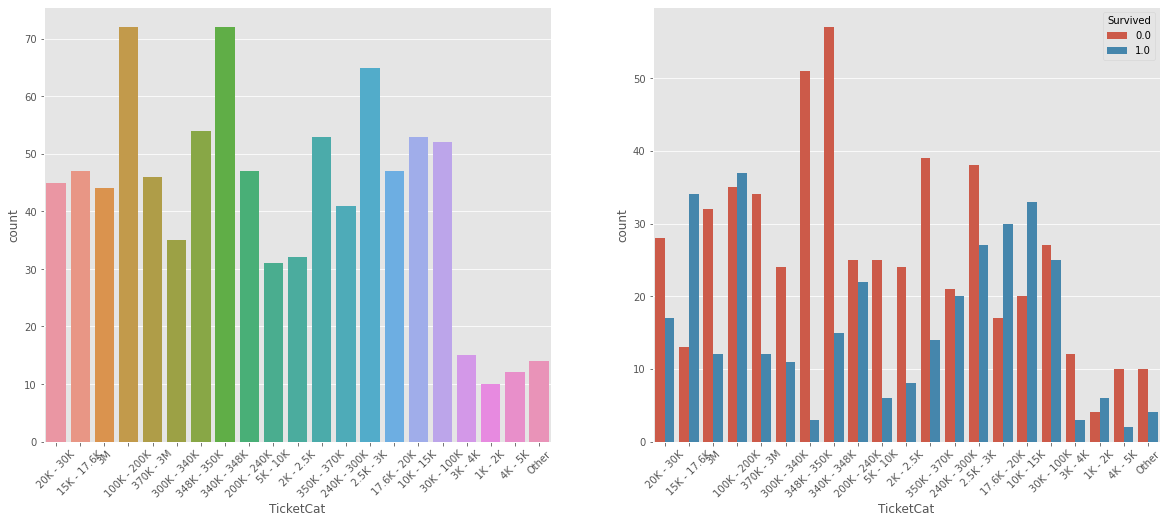

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 8))
sns.countplot(x="TicketCat", data=data, ax=ax1)
sns.countplot(x="TicketCat", hue="Survived", data=data, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45);

In order to make the Random Forest Classifier work, we'll use dummy variables for the rest of the categorical predictors: "Sex" and "Boarded".

In [16]:
data = pd.get_dummies(data, columns=["Sex", "Boarded"], drop_first=True)

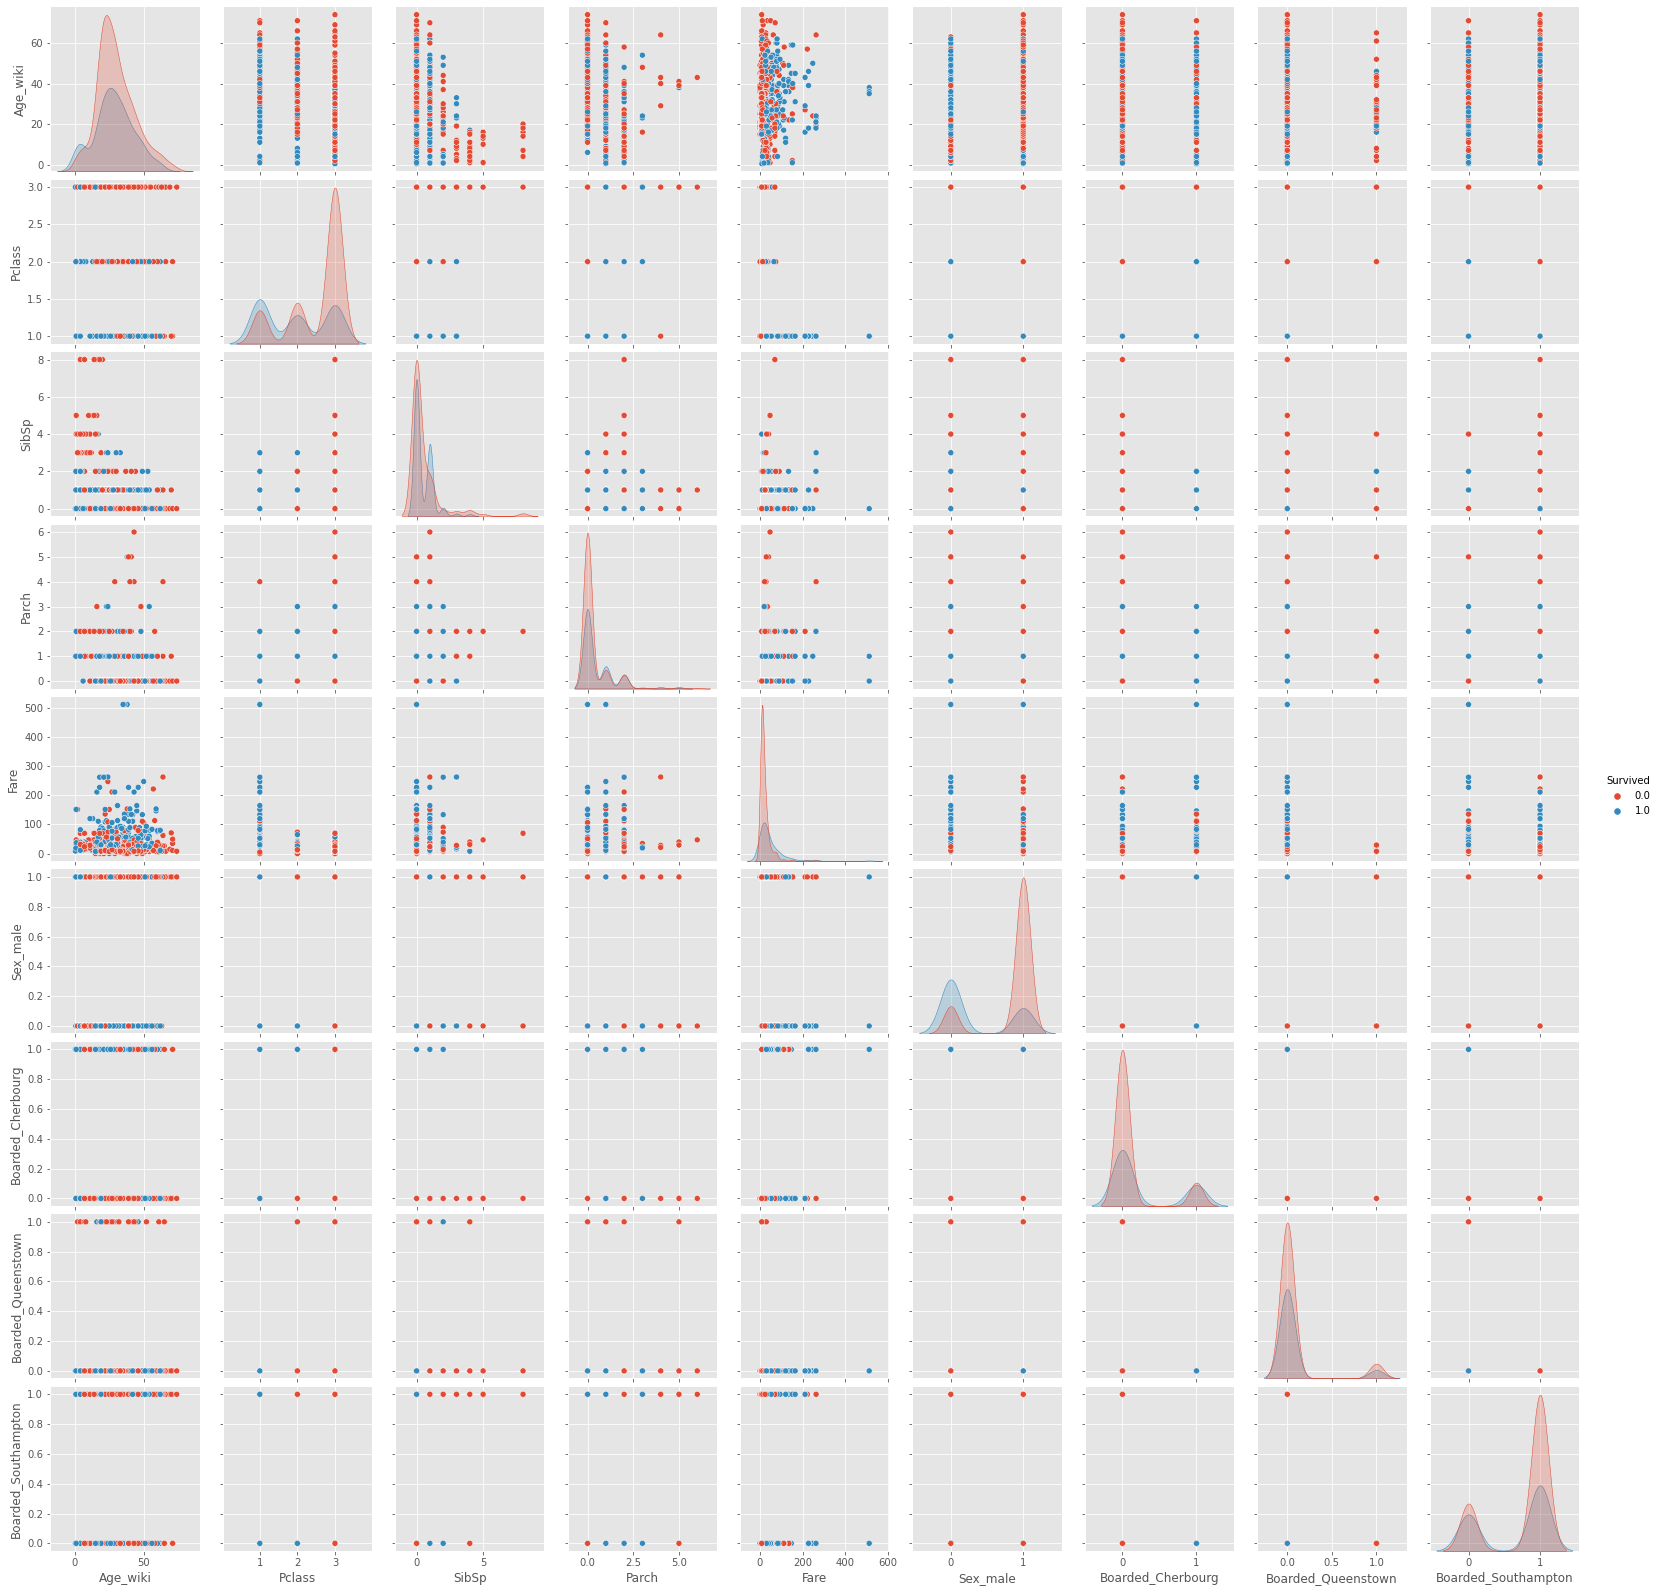

In [17]:
sns.pairplot(data, hue="Survived");

In [18]:
data["Survived"].value_counts(normalize=True)

0.0    0.615558
1.0    0.384442
Name: Survived, dtype: float64

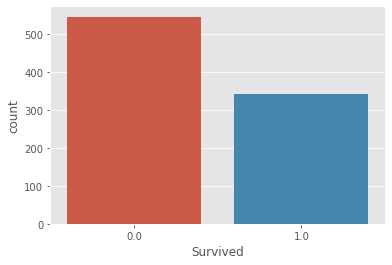

In [19]:
sns.countplot(x="Survived", data=data);

## Data preprocessing and model building

Looking at the class distribution of the response variable, we see that although it's not balanced, the imbalance is not extreme. We'll still use stratification for data splitting to get better results.

In [20]:
data.columns

Index(['Age_wiki', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Ticket', 'Survived',
       'TicketNum', 'TicketCat', 'Sex_male', 'Boarded_Cherbourg',
       'Boarded_Queenstown', 'Boarded_Southampton'],
      dtype='object')

In [21]:
response = "Survived"
predictors = data.drop([response, "Ticket", "TicketNum"], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[response], train_size=0.8, stratify=data[response])

In [22]:
comparison_items = [{
    "name": "Base",
    "model": None
}, {
    "name": "One-Hot",
    "model": ce.OneHotEncoder(cols=["TicketCat"])
}, {
    "name": "Hashing",
    "model": ce.HashingEncoder(cols=["TicketCat"], n_components=16)
}, {
    "name": "Target",
    "model": ce.TargetEncoder(cols=["TicketCat"])
}, {
    "name": "James-Stein",
    "model": ce.JamesSteinEncoder(cols=["TicketCat"])
}]

We're going to use the Random Forest Classifier with default parameters for all models. Repeated Stratified K-Fold cross-validation is going to be used to measure the performance of the models.

It's important to use pipelines for cross-validation to prevent data leakage.

In [23]:
rfc = RandomForestClassifier(n_estimators=200)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

for item in comparison_items:
    pipe = Pipeline(steps=[("enc", item["model"]), ("rfc", rfc)])
    X_train_preprocessed = X_train
    if item["model"] == None:
        X_train_preprocessed = X_train.drop(["TicketCat"], axis=1)
    scores = cross_val_score(pipe, X_train_preprocessed, y_train, cv=cv, scoring="roc_auc")
    print(item["name"], "ROC AUC:", scores.mean())

Base ROC AUC: 0.8638890146677504
One-Hot ROC AUC: 0.8583602983861605
Hashing ROC AUC: 0.8606411722589884
Target ROC AUC: 0.8621859011571655
James-Stein ROC AUC: 0.8650298192654514


Looks like all the models with the additional predictor "TicketCat" are performing similar to the "Base" model, i.e. the new categorical variable doesn't have any substantial predictive power. If there's any difference in performance, it is negligible.

Let's look at the columns for each encoding method.

In [24]:
for item in comparison_items:
    print(item["name"])
    cols = list(X_train.columns)
    if item["model"]:
        cols = list(item["model"].fit_transform(X_train, y_train).columns)
        
    print("Column Count:", len(cols))
    print("Columns:", cols)
    print()

Base
Column Count: 10
Columns: ['Age_wiki', 'Pclass', 'SibSp', 'Parch', 'Fare', 'TicketCat', 'Sex_male', 'Boarded_Cherbourg', 'Boarded_Queenstown', 'Boarded_Southampton']

One-Hot
Column Count: 30
Columns: ['Age_wiki', 'Pclass', 'SibSp', 'Parch', 'Fare', 'TicketCat_1', 'TicketCat_2', 'TicketCat_3', 'TicketCat_4', 'TicketCat_5', 'TicketCat_6', 'TicketCat_7', 'TicketCat_8', 'TicketCat_9', 'TicketCat_10', 'TicketCat_11', 'TicketCat_12', 'TicketCat_13', 'TicketCat_14', 'TicketCat_15', 'TicketCat_16', 'TicketCat_17', 'TicketCat_18', 'TicketCat_19', 'TicketCat_20', 'TicketCat_21', 'Sex_male', 'Boarded_Cherbourg', 'Boarded_Queenstown', 'Boarded_Southampton']

Hashing
Column Count: 25
Columns: ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'Age_wiki', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Boarded_Cherbourg', 'Boarded_Queenstown', 'Boarded_Southampton']

Target
Column Count: 10
Col

We see that the One-Hot model has 30 columns: 9 from the original data set and 21 additional dummy variables for each category level. The Hashing model uses additional 16 columns, which is the number we specified. Target and James-Stein don't add new columns, encoding categories to numeric values instead.

Although we already saw during cross-validation that the newly generated columns have almost no additional effect on the model performance, let's compare the performances on the test data. We'll look at ROC AUC, PR AUC and F1-Scores.

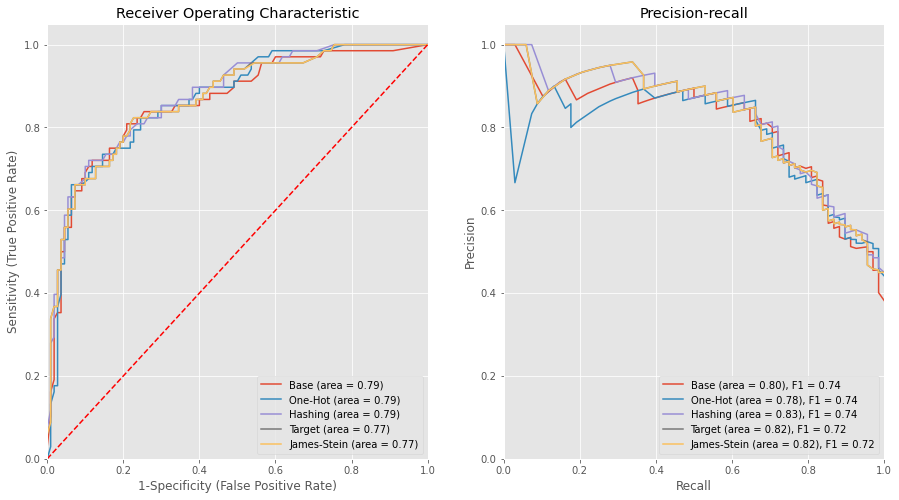

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

for item in comparison_items:
    rfc = RandomForestClassifier(n_estimators=200, random_state=1)
    
    X_train_preprocessed = X_train
    X_test_preprocessed = X_test
    if item["model"] == None:
        X_train_preprocessed = X_train.drop(["TicketCat"], axis=1)
        X_test_preprocessed = X_test.drop(["TicketCat"], axis=1)
        
    X_train_transformed = X_train_preprocessed
    X_test_transformed = X_test_preprocessed
    if item["model"]:
        X_train_transformed = item["model"].fit_transform(X_train_preprocessed, y_train)
        X_test_transformed = item["model"].transform(X_test_preprocessed)
    
    rfc.fit(X_train_transformed, y_train)
    y_pred = rfc.predict(X_test_transformed)

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test_transformed)[:,1])
    auc_score = roc_auc_score(y_test, y_pred)
    ax1.plot(fpr, tpr, label='%s (area = %0.2f)' % (item['name'], auc_score))
    
    # Precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test, rfc.predict_proba(X_test_transformed)[:,1])
    auc_score = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    ax2.plot(recall, precision, label='%s (area = %0.2f), F1 = %0.2f' % (item['name'], auc_score, f1))
    
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('1-Specificity (False Positive Rate)')
ax1.set_ylabel('Sensitivity (True Positive Rate)')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-recall')
ax2.legend(loc="lower right");

We see almost no difference in performances, and the curves look similar overall. 

However, the point of this experiment was not to test model performances of different encoding techniques, but rather understand how these techniques deal with categorical variables with a lot of levels.